In [1]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# NOTICE OF MAJOR CHANGES: 
# In SEPTEMBER 2021 this code has been altered by Olve Drageset as part of a Hackathon hosted by Statistics Norway.
# Firstly, the code is altered to run on the current generation of Google AI Platform, using Tensorflow 2.5 (instead of 2.1), and the 2.5 Tensorflow Runtime of the GCP AI Platform (instead of 2.1). 
# Secondly, the code has also been altered to load Natality data that has been extracted from an open BigQuery dataset to CSV by another notebook.
# Thirdly, the Deep Neural Network model itself and its training procedure has been altered to accomodate the Natality data.

# AI Explanations: Explaining a tabular data model

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/ai-platform-samples/tree/master/notebooks/samples/explanations/tf2/ai-explanations-tabular.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/ai-platform-samples/tree/master/notebooks/samples/explanations/tf2/ai-explanations-tabular.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

## Overview

This tutorial shows how to train a Keras model on tabular data and deploy it to the AI Explanations service to get feature attributions on your deployed model.

If you've already got a trained model and want to deploy it to AI Explanations, skip to the **Export the model as a TF 2 SavedModel** section.

### Dataset

The dataset used for this tutorial was created by combining two BigQuery Public Datasets: [London Bikeshare data](https://console.cloud.google.com/marketplace/details/greater-london-authority/london-bicycles?filter=solution-type%3Adataset&q=london%20bicycle%20hires&id=95374cac-2834-4fa2-a71f-fc033ccb5ce4) and [NOAA weather data](https://console.cloud.google.com/marketplace/details/noaa-public/gsod?filter=solution-type:dataset&q=noaa&id=c6c1b652-3958-4a47-9e58-552a546df47f). 

### Objective

The goal is to train a model using the Keras Sequential API that predicts how long a bike trip took based on the trip start time, distance, day of week, and various weather data during that day. 

This tutorial focuses more on deploying the model to AI Explanations than on the design of the model itself. 

### Costs

This tutorial uses billable components of Google Cloud Platform (GCP):

* AI Platform for:
  * Prediction
  * Explanation: AI Explanations comes at no extra charge to prediction prices. However, explanation requests take longer to process than normal predictions, so heavy usage of AI Explanations along with auto-scaling may result in more nodes being started and thus more charges
* Cloud Storage for:
  * Storing model files for deploying to Cloud AI Platform

Learn about [AI Platform
pricing](https://cloud.google.com/ml-engine/docs/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Before you begin

Make sure you're running this notebook in a **GPU runtime** if you have that option. In Colab, select **Runtime** --> **Change runtime type**


This tutorial assumes you are running the notebook either in **Colab** or **Cloud AI Platform Notebooks**.

### Set up your GCP project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a GCP project.](https://console.cloud.google.com/cloud-resource-manager)

2. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)

3. [Enable the AI Platform Training & Prediction and Compute Engine APIs.](https://console.cloud.google.com/flows/enableapi?apiid=ml.googleapis.com,compute_component)

4. Enter your project ID in the cell below. Then run the  cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Project ID

**If you don't know your project ID.**

You might able to get your project ID using `gcloud` command, by executing the second code block below.

In [2]:
PROJECT_ID = "hack4ssb-team1" #@param {type:"string"}

In [3]:
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)

In [4]:
!gcloud config set project $PROJECT_ID

Updated property [core/project].


#### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where Cloud
AI Platform services are
available](https://cloud.google.com/ml-engine/docs/tensorflow/regions). You can
not use a Multi-Regional Storage bucket for training with AI Platform.

In [5]:
REGION = 'europe-west3' #@param {type: "string"}

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, we create a timestamp for each instance session, and append onto the name of resources which will be created in this tutorial.

In [6]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Authenticate your GCP account

**If you are using AI Platform Notebooks**, your environment is already
authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions
when prompted to authenticate your account via oAuth.

In [7]:
import sys
import os
import warnings

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# If you are running this notebook in Colab, follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.


def install_dlvm_packages():
    ! pip install tabulate


if 'google.colab' in sys.modules:
    from google.colab import auth as google_auth
    google_auth.authenticate_user()
    ! pip install witwidget --quiet
    ! pip install tensorflow==2.5 --quiet
    ! gcloud config set project $PROJECT_ID

elif "DL_PATH" in os.environ:
    install_dlvm_packages()

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

When you submit a training job using the Cloud SDK, you upload a Python package
containing your training code to a Cloud Storage bucket. AI Platform runs
the code from this package. In this tutorial, AI Platform also saves the
trained model that results from your job in the same bucket. You can then
create an AI Platform model version based on this output in order to serve
online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets. 

In [8]:
BUCKET_NAME = "dev-xai" #@param {type:"string"}

In [9]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "[your-bucket-name]":
    BUCKET_NAME = PROJECT_ID + "_xai_flowers_" + TIMESTAMP

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [10]:
! gsutil mb -l $REGION gs://$BUCKET_NAME

Creating gs://dev-xai/...
ServiceException: 409 A Cloud Storage bucket named 'dev-xai' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


### Import libraries

Import the libraries for this tutorial. This tutorial has been tested with **TensorFlow versions 2.1 and 2.2**.

In [11]:
import tensorflow as tf
import pandas as pd

# should be >= 2.5
print("Tensorflow version " + tf.__version__)
if tf.__version__ < "2.5":
    raise Exception("TF 2.5 or greater is required")

!pip install explainable-ai-sdk
import explainable_ai_sdk

Tensorflow version 2.5.0


## Download and preprocess the data

In this section you'll download the data to train your model from a public GCS bucket. The original data is from the BigQuery datasets linked above. For your convenience, we've joined the London bike and NOAA weather tables, done some preprocessing, and provided a subset of that dataset here.


In [12]:
# GET DATA

### Read the data with Pandas

You'll use Pandas to read the data into a `DataFrame` and then do some additional pre-processing.

In [13]:
train_data = pd.read_csv('train.csv', names=['weight_pounds', 'is_male', 'mother_age', 'plurality', 'gestation_weeks', 'key'])
eval_data = pd.read_csv('eval.csv', names=['weight_pounds', 'is_male', 'mother_age', 'plurality', 'gestation_weeks', 'key'])
data = pd.concat([train_data, eval_data])

# Shuffle the data
data = data.sample(frac=1, random_state=2)

Let's take a look at the first five rows of your data in the panda dataframe

In [14]:
# Preview the first 5 rows
print(f"length of data: {len(data)}")
data.head()

length of data: 16336


,weight_pounds,is_male,mother_age,plurality,gestation_weeks,key
5237,8.157104,0,30,1,40.0,8599690069971956834
2471,7.198093,1,18,1,39.0,-1866590652208008467
3759,9.186662,0,21,1,41.0,7586701093880244808
3414,7.625790,1,28,1,35.0,3042228741091961920
1065,7.874912,1,30,1,40.0,5934265245228309013


Next, you will separate the data into features ('data') and labels ('labels')

In [15]:
# Save duration to its own DataFrame and remove it from the original DataFrame
labels = data['weight_pounds']
data = data.drop(columns=['weight_pounds', 'key'])

### Split data into train and test sets

You'll split your data into train and test sets using an 80 / 20 train / test split.

In [16]:
# Use 80/20 train/test split
train_size = int(len(data) * .8)

# Split your data into train and test sets
train_data = data[:train_size]
train_labels = labels[:train_size]
print("Train size: %d" % len(train_data))

test_data = data[train_size:]
test_labels = labels[train_size:]
print("Test size: %d" % len(test_data))

Train size: 13068
Test size: 3268


## Build, train, and evaluate your model with Keras

This section shows how to build, train, evaluate, and get local predictions from a model by using the Keras [Sequential API](https://www.tensorflow.org/guide/keras/sequential_model). The model will takes your 10 features as input and predict the trip duration in minutes.

In [44]:
from tensorflow.keras import initializers
input_dimensions=len(train_data.iloc[0])
print(f"input dimensions: {input_dimensions}")
# Build your model
model = tf.keras.Sequential(name="babyweight_predict")
model.add(tf.keras.layers.Dense(64, 
                                input_dim=len(train_data.iloc[0]), 
                                activation='sigmoid', 
                                kernel_initializer=initializers.RandomNormal(stddev=0.01),
                                bias_initializer=initializers.Zeros()))
model.add(tf.keras.layers.Dense(32, 
                                activation='sigmoid', 
                                kernel_initializer=initializers.RandomNormal(stddev=0.0¢1),
                                bias_initializer=initializers.Zeros()))
model.add(tf.keras.layers.Dense(1, activation="linear"))

input dimensions: 4


In [18]:
# Compile the model and see a summary
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='mean_squared_logarithmic_error', optimizer=optimizer)
model.summary()

Model: "babyweight_predict"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,433
Trainable params: 2,433
Non-trainable params: 0
_________________________________________________________________


### Create an input data pipeline with tf.data

In [19]:
batch_size = 64
epochs = 10

input_train = tf.data.Dataset.from_tensor_slices(train_data)
print(len(input_train))
output_train = tf.data.Dataset.from_tensor_slices(train_labels)
input_train = input_train.batch(batch_size, drop_remainder=True)
nr_of_batches = print(len(input_train))
input_train = input_train.repeat()
output_train = output_train.batch(batch_size, drop_remainder=True).repeat()
train_dataset = tf.data.Dataset.zip((input_train, output_train))

13068
204


### Train the model

In [20]:
# This will take about a minute to run
# To keep training time short, you're not using the full dataset
model.fit(train_dataset, steps_per_epoch=train_size // batch_size, epochs=epochs)

Epoch 1/10
204/204 [==============================] - 1s 1ms/step - loss: 0.0682
Epoch 2/10
204/204 [==============================] - 0s 1ms/step - loss: 0.0381
Epoch 3/10
204/204 [==============================] - 0s 1ms/step - loss: 0.0380
Epoch 4/10
204/204 [==============================] - 0s 1ms/step - loss: 0.0357
Epoch 5/10
204/204 [==============================] - 0s 1ms/step - loss: 0.0288
Epoch 6/10
204/204 [==============================] - 0s 1ms/step - loss: 0.0280
Epoch 7/10
204/204 [==============================] - 0s 1ms/step - loss: 0.0264
Epoch 8/10
204/204 [==============================] - 0s 1ms/step - loss: 0.0257
Epoch 9/10
204/204 [==============================] - 0s 1ms/step - loss: 0.0236
Epoch 10/10
204/204 [==============================] - 0s 1ms/step - loss: 0.0228


### Evaluate the trained model locally

In [21]:
# Run evaluation
results = model.evaluate(test_data, test_labels)
print(results)

103/103 [==============================] - 0s 835us/step - loss: 0.0235
0.023524289950728416


In [22]:
# Send test instances to model for prediction
predict = model.predict(test_data[:5])

In [23]:
# Preview predictions on the first 5 examples from your test dataset
for i, val in enumerate(predict):
    print('Predicted weight: {}'.format(round(val[0])))
    print('Actual weight: {} \n'.format(test_labels.iloc[i]))

Predicted weight: 7
Actual weight: 9.25059651352 

Predicted weight: 7
Actual weight: 6.75055446244 

Predicted weight: 7
Actual weight: 7.495716907999999 

Predicted weight: 7
Actual weight: 8.375361333379999 

Predicted weight: 7
Actual weight: 5.37486994756 



## Export the model as a TF 2.x SavedModel

When using TensorFlow 2.x, you export the model as a `SavedModel` and load it into Cloud Storage. 

In [24]:
export_path = 'gs://' + BUCKET_NAME + '/explanations/mymodel'
model.save(export_path)
print(export_path)

INFO:tensorflow:Assets written to: gs://dev-xai/explanations/mymodel/assets
gs://dev-xai/explanations/mymodel


Use TensorFlow's `saved_model_cli` to inspect the model's SignatureDef. You'll use this information when you deploy your model to AI Explanations in the next section.

In [25]:
! saved_model_cli show --dir $export_path --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['dense_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 4)
        name: serving_default_dense_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_2'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Defined Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          inputs: TensorSpec(

## Deploy the model to AI Explanations

In order to deploy the model to Explanations, you need to generate an `explanations_metadata.json` file and upload this to the Cloud Storage bucket with your SavedModel. Then you'll deploy the model using `gcloud`.

### Prepare explanation metadata

In order to deploy this model to AI Explanations, you need to create an explanation_metadata.json file with information about your model inputs, outputs, and baseline. You can use the [Explainable AI SDK](https://pypi.org/project/explainable-ai-sdk/) to generate most of the fields. 

The value for `input_baselines` tells the explanations service what the baseline input should be for your model. Here you're using the median for all of your input features. That means the baseline prediction for this model will be the trip duration your model predicts for the median of each feature in your dataset. 

Since this model accepts a single numpy array with all numerical feature, you can optionally pass an `index_feature_mapping` list to AI Explanations to make the API response easier to parse. When you provide a list of feature names via this parameter, the service will return a key / value mapping of each feature with its corresponding attribution value.

In [26]:
# Print the names of your tensors
print(model.input)
print('Model input tensor name: ', model.input.name)
print('Model output tensor name: ', model.output.name)

KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name='dense_input'), name='dense_input', description="created by layer 'dense_input'")
Model input tensor name:  dense_input
Model output tensor name:  dense_2/BiasAdd:0


In [27]:
from explainable_ai_sdk.metadata.tf.v2 import SavedModelMetadataBuilder
builder = SavedModelMetadataBuilder(export_path)
builder.set_numeric_metadata(
    model.input.name.split(':')[0],
    input_baselines=[train_data.median().values.tolist()],
    index_feature_mapping=train_data.columns.tolist()
)
builder.save_metadata(export_path)

Since this is a regression model (predicting a numerical value), the baseline prediction will be the same for every example you send to the model. If this were instead a classification model, each class would have a different baseline prediction.

### Create the model

In [28]:
import datetime
MODEL = 'natality' + datetime.datetime.now().strftime("%d%m%Y%H%M%S")

In [29]:
# Create the model if it doesn't exist yet (you only need to run this once)
! gcloud ai-platform models create $MODEL --enable-logging --region=$REGION

Using endpoint [https://europe-west3-ml.googleapis.com/]
Created ai platform model [projects/hack4ssb-team1/models/natality30092021114230].


### Create the model version 

Creating the version will take ~5-10 minutes. Note that your first deploy could take longer.

In [30]:
# Each time you create a version the name should be unique
VERSION = 'v1'

In [31]:
# Create the version with gcloud
explain_method = 'integrated-gradients'
! gcloud beta ai-platform versions create $VERSION --region=$REGION \
--model $MODEL \
--origin $export_path \
--runtime-version 2.5 \
--framework TENSORFLOW \
--python-version 3.7 \
--machine-type n1-standard-4 \
--explanation-method $explain_method \
--num-integral-steps 25

Using endpoint [https://europe-west3-ml.googleapis.com/]
Explanations reflect patterns in your model, but don't necessarily reveal fundamental relationships about your data population. See https://cloud.google.com/ml-engine/docs/ai-explanations/limitations for more information.
Creating version (this might take a few minutes)......done.                    


In [32]:
# Make sure the model deployed correctly. State should be `READY` in the following log
! gcloud ai-platform versions describe $VERSION --model $MODEL --region=$REGION

Using endpoint [https://europe-west3-ml.googleapis.com/]
createTime: '2021-09-30T11:42:43Z'
deploymentUri: gs://dev-xai/explanations/mymodel
etag: csjbOCoLG9I=
explanationConfig:
  integratedGradientsAttribution:
    numIntegralSteps: 25
framework: TENSORFLOW
isDefault: true
machineType: n1-standard-4
name: projects/hack4ssb-team1/models/natality30092021114230/versions/v1
pythonVersion: '3.7'
runtimeVersion: '2.5'
state: READY


## Get predictions and explanations

Now that your model is deployed, you can use the AI Platform Prediction API to get feature attributions. You'll pass it a single test example here and see which features were most important in the model's prediction. Here you'll use the [Explainable AI SDK](https://pypi.org/project/explainable-ai-sdk/) to get your prediction and explanation. You can also use `gcloud`.

### Format your explanation request

To make your AI Explanations request, you need to create a JSON object with your test data for prediction.

In [33]:
# Format data for prediction to your model
print(model.input.name)
prediction_json = {model.input.name.split(':')[0]: test_data.iloc[0].values.tolist()}
print(prediction_json)

dense_input
{'dense_input': [0.0, 34.0, 1.0, 40.0]}


### Send the explain request

You can use the Explainable AI SDK to send explanation requests to your deployed model.

In [34]:
print(f"Load model '{MODEL}' version '{VERSION}' in project '{PROJECT_ID}' on region {REGION} from ai platform...")
remote_ig_model = explainable_ai_sdk.load_model_from_ai_platform(PROJECT_ID, MODEL, VERSION, region=REGION)
instances = [prediction_json]
predictions = remote_ig_model.predict(instances)
ig_response = remote_ig_model.explain(instances)
print("Done predicting and explaining instances")

Load model 'natality30092021114230' version 'v1' in project 'hack4ssb-team1' on region europe-west3 from ai platform...
Done predicting and explaining instances


### Understanding the explanations response

First, let's look at the trip duration your model predicted and compare it to the actual value

In [42]:
attr = ig_response[0].get_attribution()

predicted = round(attr.example_score, 2)
print('Predicted weight: ' + str(predicted) + ' pounds')
print('Actual weight: ' + str(test_labels.iloc[0]) + ' pounds')

Predicted weight: 7.15 pounds
Actual weight: 9.25059651352 pounds


Next let's look at the feature attributions for this particular example. Positive attribution values mean a particular feature pushed your model prediction up by that amount, and vice versa for negative attribution values.

Label Index 0
Example Score: 7.1513
Baseline Score: 7.1329
Approximation Error: 0.0004


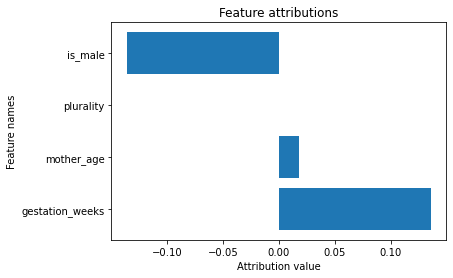

In [43]:
ig_response[0].visualize_attributions()

## Check your explanations and baselines

To better make sense of the feature attributions you're getting, you should compare them with your model's baseline. In most cases, the sum of your attribution values + the baseline should be very close to your model's predicted value for each input. Also note that for regression models, the `baseline_score` returned from AI Explanations will be the same for each example sent to your model. For classification models, each class will have its own baseline.

In this section you'll send 10 test examples to your model for prediction in order to compare the feature attributions with the baseline. Then you'll run each test example's attributions through two sanity checks in the `sanity_check_explanations` method.

In [45]:
# Prepare 10 test examples to your model for prediction
pred_batch = []
for i in range(10):
    pred_batch.append({model.input.name.split(':')[0]: test_data.iloc[i].values.tolist()})

In [46]:
test_response = remote_ig_model.explain(pred_batch)

ValueError: Target URI https://europe-west3-ml.googleapis.com/v1/projects/hack4ssb-team1/models/natality30092021114230/versions/v1:explain returns HTTP 400 error.
Please check the raw error message: 
{
  "error": {
    "code": 400,
    "message": "{\"error\": \"Unable to explain the requested instance(s) because: Conversion failed. Key dense_3_input not in key map {'dense_input': 'dense_input'}.\"}",
    "status": "INVALID_ARGUMENT"
  }
}


In the function below you perform two sanity checks for models using Integrated Gradient (IG) explanations and one sanity check for models using Sampled Shapley.

In [47]:
def sanity_check_explanations(example, mean_tgt_value=None, variance_tgt_value=None):
    passed_test = 0
    total_test = 1
    # `attributions` is a dict where keys are the feature names
    # and values are the feature attributions for each feature
    attr = example.get_attribution()
    baseline_score = attr.baseline_score
    # sum_with_baseline = np.sum(attribution_vals) + baseline_score
    predicted_val = attr.example_score

    # Sanity check 1
    # The prediction at the input is equal to that at the baseline.
    #  Please use a different baseline. Some suggestions are: random input, training
    #  set mean.
    if abs(predicted_val - baseline_score) <= 0.05:
        print('Warning: example score and baseline score are too close.')
        print('You might not get attributions.')
    else:
        passed_test += 1

    # Sanity check 2 (only for models using Integrated Gradient explanations)
    # Ideally, the sum of the integrated gradients must be equal to the difference
    # in the prediction probability at the input and baseline. Any discrepency in
    # these two values is due to the errors in approximating the integral.
    if explain_method == 'integrated-gradients':
        total_test += 1
        want_integral = predicted_val - baseline_score
        got_integral = sum(attr.post_processed_attributions.values())
        if abs(want_integral - got_integral) / abs(want_integral) > 0.05:
            print('Warning: Integral approximation error exceeds 5%.')
            print('Please try increasing the number of integrated gradient steps.')
        else:
            passed_test += 1

    print(passed_test, ' out of ', total_test, ' sanity checks passed.')

In [48]:
for response in test_response:
    sanity_check_explanations(response)

You might not get attributions.
1  out of  2  sanity checks passed.
2  out of  2  sanity checks passed.
You might not get attributions.
1  out of  2  sanity checks passed.
2  out of  2  sanity checks passed.
2  out of  2  sanity checks passed.
2  out of  2  sanity checks passed.
2  out of  2  sanity checks passed.
2  out of  2  sanity checks passed.
2  out of  2  sanity checks passed.
You might not get attributions.
1  out of  2  sanity checks passed.


## Understanding AI Explanations with the What-If Tool

In this section you'll use the [What-If Tool](https://pair-code.github.io/what-if-tool/) to better understand how your model is making predictions. See the cell below the What-if Tool for visualization ideas.

The What-If-Tool expects data with keys for each feature name, but your model expects a flat list. The functions below convert data to the format required by the What-If Tool.

In [49]:
# This is the number of data points you'll send to the What-if Tool
WHAT_IF_TOOL_SIZE = 500

from witwidget.notebook.visualization import WitWidget, WitConfigBuilder


def create_list(ex_dict):
    new_list = []
    for i in feature_names:
        new_list.append(ex_dict[i])
    return new_list


def example_dict_to_input(example_dict):
    return {'dense_input': create_list(example_dict)}


from collections import OrderedDict
wit_data = test_data.iloc[:WHAT_IF_TOOL_SIZE].copy()
wit_data['duration'] = test_labels[:WHAT_IF_TOOL_SIZE]
wit_data_dict = wit_data.to_dict(orient='records', into=OrderedDict)

In [50]:
config_builder = WitConfigBuilder(
    wit_data_dict
).set_ai_platform_model(
    PROJECT_ID,
    MODEL,
    VERSION,
    adjust_example=example_dict_to_input
).set_target_feature('duration').set_model_type('regression')

WitWidget(config_builder)

WitWidget(config={'model_type': 'regression', 'label_vocab': [], 'uses_json_input': True, 'inference_address':…

### What-If Tool visualization ideas

On the x-axis, you'll see the predicted trip duration for the test inputs you passed to the What-If Tool. Each circle represents one of your test examples. If you click on a circle, you'll be able to see the feature values for that example along with the attribution values for each feature. 

* You can edit individual feature values and re-run prediction directly within the What-If Tool. Try changing `distance`, click **Run inference** and see how that affects the model's prediction
* You can sort features for an individual example by their attribution value, try changing the sort from the attributions dropdown
* The What-If Tool also lets you create custom visualizations. You can do this by changing the values in the dropdown menus above the scatter plot visualization. For example, you can sort data points by inference error, or by their similarity to a single datapoint.

## Cleaning up

To clean up all GCP resources used in this project, you can [delete the GCP
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Alternatively, you can clean up individual resources by running the following
commands:

In [ ]:
# Delete model version resource
# ! gcloud ai-platform versions delete $VERSION --quiet --model $MODEL --region $REGION

# Delete model resource
# ! gcloud ai-platform models delete $MODEL --quiet --region $REGION

# Delete Cloud Storage objects that were created
# ! gsutil -m rm -r gs://$BUCKET_NAME --region $REGION

If your Cloud Storage bucket doesn't contain any other objects and you would like to delete it, run `gsutil rm -r gs://$BUCKET_NAME`.

## What's next?

To learn more about AI Explanations or the What-if Tool, check out the resources here.

* [AI Explanations documentation](cloud.google.com/ml-engine/docs/ai-explanations)
* [Documentation for using the What-if Tool with Cloud AI Platform models ](https://cloud.google.com/ml-engine/docs/using-what-if-tool) 
* [What-If Tool documentation and demos](https://pair-code.github.io/what-if-tool/)
* [Integrated gradients paper](https://arxiv.org/abs/1703.01365)